In [143]:

import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
from PIL import Image
from matplotlib.pyplot import imshow
import utils
import cv2
%matplotlib inline

uint8
float64
(64, 64)
(64, 64, 2)
float64
uint8
(256, 256, 3)
(256, 256, 3)  a


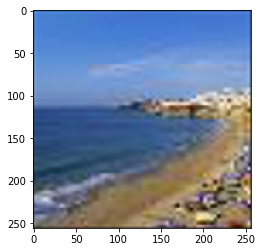

In [241]:
f = [x.strip("\n") for x in open("train.txt")]
img = utils.read_image("color_64/"+str(f[16]))
print(img.dtype)
l = utils.cvt2Lab(img)
print(l[1].dtype)

print(l[0].shape)
print(l[1].shape)
L = utils.upsample(l[0])
ab = utils.upsample(l[1])
lab_img = np.stack((L,ab[:,:,0],ab[:,:,1]),axis=2)
print(lab_img.dtype)
img2 = utils.cvt2rgb(lab_img)
print(img.dtype)
print(lab_img.shape)
print(img2.shape," a")
imshow(img2)


In [243]:
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import utils

class ImageDataset(Dataset):
    def __init__(self, type="train" , transform=[] ):
        
        if(type=="train"):
            self.pictures = [x.strip("\n") for x in open("train.txt")]
        else:
            self.pictures = [x.strip("\n") for x in open("valid.txt")]
            
            
        
        self.transform = transform
        self.scaler = transforms.Resize((256, 256))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.pictures)

    def __getitem__(self, idx):
        
        img_gray = utils.read_image("gray/"+self.pictures[idx])
        img_256 = utils.read_image("color_256/"+self.pictures[idx])
        img_64 = utils.read_image("color_64/"+self.pictures[idx])
        
        #convert to L
        gray_L, gray_ab = utils.cvt2Lab(img_gray)
        rgb_64_L, rgb_64_ab = utils.cvt2Lab(img_64)

        #normalize to [-1,1]
        gray_L, gray_ab = (gray_L-50)/50, gray_ab/128
        rgb_64_L, rgb_64_ab = (rgb_64_L-50)/50 , rgb_64_ab/128

        # HxWxC to CxHxW
        rgb_256 = np.transpose(img_256 , (2,0,1))
        rgb_64_ab = np.transpose(rgb_64_ab , (2,0,1))
        gray_ab = np.transpose(gray_ab , (2,0,1))
        
        #add 1 auxilary channel to L
        gray_L = np.expand_dims(gray_L,axis=0)
        rgb_64_L = np.expand_dims(rgb_64_L,axis=0)
        
        rgb_256 = torch.from_numpy(rgb_256)
        gray_L = torch.from_numpy(gray_L)
        gray_ab = torch.from_numpy(gray_ab)
        rgb_64_L = torch.from_numpy(rgb_64_L)
        rgb_64_ab = torch.from_numpy(rgb_64_ab)
        
        
        
        """
        for trs in self.transform:
            img = trs(img)
        """
        
        return gray_L, gray_ab, rgb_64_L, rgb_64_ab, rgb_256

In [279]:
def toRgb256(L,ab):
    L = L.numpy()
    ab = ab.numpy()
    print(L.dtype)
    print(ab.dtype)
    assert L.shape[0]==ab.shape[0],"Unmatching batch sizes"
    
    ab = np.transpose(ab,(0,2,3,1))
    L = np.transpose(L,(0,2,3,1))


    #denormalize from [-1,1] to [-128,127]
    ab = ab*128
    
    ab[ab>127] = 128
    ab[ab<-127] = -127
    #denormalize from [-1,1] to [0,100]
    L = L*50+50
    
    L[L>100] = 100
    L[L<0] = 0

    #upsample form 64 to 256
    upsampled_ab = np.zeros((ab.shape[0],256,256,2))
    for i in range(ab.shape[0]):
        #i have no idea why i multiple with 100, but it does not work otherwise
        upsampled_ab[i] = utils.upsample(ab[i])
    ab = upsampled_ab
    
    assert L.shape[0]==ab.shape[0] and \
         L.shape[1:3] == ab.shape[1:3],"Unmatching shapes sizes"

    lab_img = np.stack((L[:,:,:,0],ab[:,:,:,0],ab[:,:,:,1]),axis=3)
    
    for i in range(lab_img.shape[0]):
        lab_img[i] = utils.cvt2rgb(lab_img[i])

    return lab_img

In [254]:
def calc_acc(estimations,names_file):
    with open(names_file, "r") as f:
        files = f.readlines()
    acc = 0
    for i, filem in enumerate(files):
        cur = utils.read_image("color_256/" + filem.rstrip()).reshape(-1).astype(np.int64)
        est = estimations[i].reshape(-1).astype(np.int64)
    
        cur_acc = (np.abs(cur - est) < 12).sum() / cur.shape[0]
        acc += cur_acc
    acc /= len(files)
    
    return acc

float64
float64
0


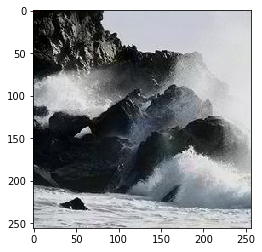

In [280]:
dset = ImageDataset()
loader = DataLoader(dset, batch_size=1,
                        shuffle=True, num_workers=4)

for a,b,c,d,e in loader:
    break

"""
an = np.transpose(a.numpy(),(0,2,3,1))
dn = np.transpose(d.numpy(),(0,2,3,1))
print(an.shape," an shape")
print(dn.shape, "dn shape")
L = an[0]
#denormalize from [-1,1] to [-128,127]
ab = ab*128
ab = ab.astype(np.int8)

#denormalize from [-1,1] to [0,100]
L = L*50+50
L = L.astype(np.int8)


ab = utils.upsample(dn[0])*100
print(ab)
#ab = cv2.resize(dn[0], dsize=(256, 256), interpolation=cv2.INTER_CUBIC)*100
print(ab.dtype)
print(ab)

print(ab.shape," ab shape")
print(L[:,:,0].shape," L shape")
lab_img = np.stack((L[:,:,0],ab[:,:,0],ab[:,:,1]),axis=2)
img2 = utils.cvt2rgb(lab_img)
print(lab_img.shape, " lab img shape")
print(img2.shape," img2 shape")
imshow(img2)
"""



f = toRgb256(a,d)
print((f>1).sum())
f = (f*255).astype(np.uint8)
imshow(f[0])


(256, 256, 3)


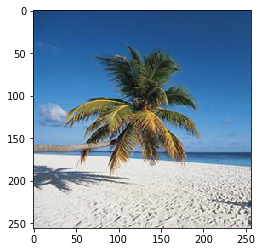

In [264]:
e=np.transpose(e.numpy(),(0,2,3,1))
print(e[0].shape)
imshow(e[0])